# Part 5: Homography + RANSAC

### 1.Load im01.jpg and im02.jpg. Based on SIFT, find matches between the two images. Show all the matches, similar to:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import random as rm
import math
import cv2
from tkinter import *
from tkinter import messagebox
from PIL import Image, ImageTk
import random

In [2]:
# import the image
im1 = cv2.imread('im01.jpg',cv2.IMREAD_COLOR)
im2 = cv2.imread('im02.jpg',cv2.IMREAD_COLOR)
img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

In [3]:
# show input image
input_images=np.hstack((im1,im2))
cv2.imshow('Input Images',input_images)
cv2.waitKey(0)
cv2.destroyWindow('Input Images')
cv2.waitKey(1)

-1

In [4]:
# mini square
def mini_square(des1,des2):
    [p1,n] = des1.shape
    [p2,n] = des2.shape
    
    # find mini distance position
    # return the matches relationship of both sides
    matches1 = []
    for j in range(0,p1):
        dis = np.zeros([p2,1])
        for k in range(0,p2):
            v = des1[j]-des2[k]
            dis[k] = np.dot(v,v.T)
            
        # find the mini position
        pos = np.argmin(dis)
        # _distance should not be float
        tmp = int(dis[pos])
        
        # store the position in DMatch
        matches1.append(cv2.DMatch(_distance=tmp,_queryIdx=j,_trainIdx=pos,_imgIdx=0))

    matches2 = []
    for j in range(0,p2):
        dis = np.zeros([p1,1])
        for k in range(0,p1):
            v = des2[j]-des1[k]
            dis[k] = np.dot(v,v.T)
            
        # find the mini position
        pos = np.argmin(dis)
        tmp = int(dis[pos])
        
        # store the position in DMatch
        matches2.append(cv2.DMatch(_distance=tmp,_queryIdx=j,_trainIdx=pos,_imgIdx=0))
    
    # matches points that are same in query index and train index
    matches = []
    for i in matches1:
        for j in matches2:
            if i.queryIdx == j.trainIdx and i.trainIdx == j.queryIdx:
                matches.append(i)
    
    return matches
                

In [5]:
# Find SIFT and return Homography Matrix
def SIFT(im1, im2):
    # im1 and im2 are grayscale image

    # Initialize SIFT 
    sift=cv2.SIFT_create() 
    
    # turn to grayscale
    im1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

    # Extract keypoints and descriptors
    kp1,des1=sift.detectAndCompute(im1,None)
    kp2,des2=sift.detectAndCompute(im2,None)

    # match the points
    # using DMatch instead of matrix. matrix not so powerful and easily went wrong
    matches = mini_square(des1,des2)
    
#     # Bruteforce matcher on the descriptors
#         another way to match the pairs of points using KNN

#     bruteforce=cv2.BFMatcher()
#     matches=bruteforce.knnMatch(des1,des2, k=2)

#     # Make sure that the matches are good
#     verify_ratio=0.8 
#     verified_matches=[]
#     for m1,m2 in matches:
#         # Add to array only if it's a good match
#         if m1.distance<0.8*m2.distance:
#             #turn DMatch to matrix
#             verified_matches.append([m1.queryIdx,m1.trainIdx])

#     verified_matches = np.matrix(verified_matches)

    # Mimnum number of matches
    min_matches=8
    if len(matches)>min_matches:
        return matches,kp1,kp2
    else:
        print('Error: Not enough matches')
        exit()

In [6]:
# Use SIFT to find keypoints and match the keypoints
[kpm,kp1,kp2] = SIFT(im1, im2)

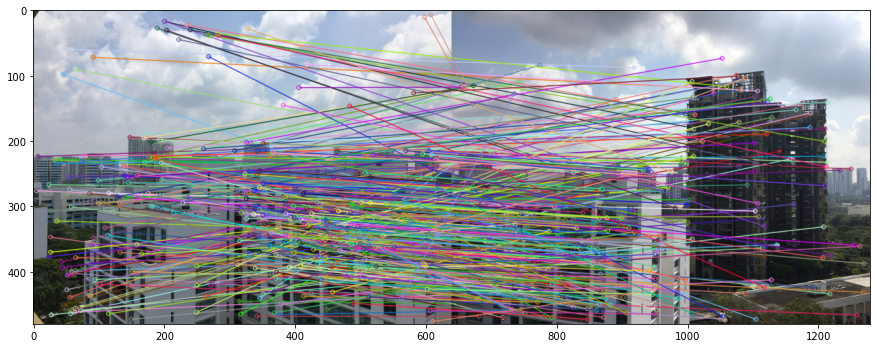

In [7]:
# method 1
# plot matching line

match_res = cv2.drawMatches(img1, kp1, img2, kp2, kpm, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure( figsize=(15,15) )
plt.imshow(match_res)
plt.show()

In [8]:
# method 2
# plot matching line
mat_images=np.hstack((im1,im2))
line_num = len(kpm)
_,y_com,_ = im1.shape

line_size = 1
thickness = 1 #  0, 2, 4, 8

# draw lines between matching pairs of points
for index in kpm:
    # random color
    bgr = np.random.randint(0, 255, 3, dtype=np.int32)

    # ps-the start of the line
    # pe-the end of the line
    ps = int(index.queryIdx)
    pe = int(index.trainIdx)

    # draw line
    cv2.line(mat_images,[int(kp1[ps].pt[0]),int(kp1[ps].pt[1])],
             [int(kp2[pe].pt[0]+y_com),int(kp2[pe].pt[1])],(int(bgr[0]),int(bgr[1]),int(bgr[2])),thickness)

# show the matching points
cv2.imshow('Matches points Images',mat_images)
cv2.waitKey(0)
cv2.destroyWindow('Matches points Images')
cv2.waitKey(1)

-1

### 2.Compute the best homography matrix using RANSAC, and show all the inlier matches (matches that support your best homography matrix):

In [9]:
# homography computing
def hmat(points):
    row = len(points)
    n_mat = int(row/2)
    A = np.zeros([row,9])
    
    for i in range(0,n_mat):
        h1_x = points[i][0]
        h1_y = points[i][1]
        h2_x = points[i+n_mat][0]
        h2_y = points[i+n_mat][1]
        A[2*i][:] = [h1_x,h1_y,1,0,0,0,-h2_x*h1_x,-h2_x*h1_y,-h2_x]
        A[2*i+1][:] = [0,0,0,h1_x,h1_y,1,-h2_y*h1_x,-h2_y*h1_y,-h2_y]

    _, _, vt = linalg.svd(A)
    H = vt[-1].reshape(3,3)
    H = H / H[2,2] # H(3,3) = 1

    return H

In [10]:
# count inliers
def inlier(H,mp,matches,threshold):
    row = len(mp)
    p1 = mp[:,0:2]
    p2 = mp[:,2:4]
    
    x1 = np.concatenate((p1,np.ones([row,1])),axis = 1)
    # transfer 
    x2 = np.dot(H,x1.T)
    x2 = x2[0:2,:]/x2[2,:]
    es_p2 = x2[0:2,:].T
    
    # distance
    diff = p2 - es_p2
    sq = diff * diff
    dis = np.sqrt(sq[:,0] + sq[:,1])
    
    # calculate the number of points that distance < threshold
    # inliers' position
    match = []
    for i in range(0,row):
        if dis[i] < threshold:
            match.append(matches[i])
    
    return match

In [11]:
# find whether there is same value in a matrix
def judgequale(a):
    count = 0
    # sort the matrix by the 1st col
    a = np.sort(a)
    while True:
        if a[count,0] == a[count+1,0]:
            return True
        elif count == len(a)-2:
            return False
        else:
            count += 1

In [12]:
# RANSAC + Homography
def homo_ransac(kp1,kp2,matches,repeat):
    # n the pairs of keypoints selected randomly (n >= 4)
    n = 4
    # loop times
    loop = repeat
    # HH the largest inliers H
    HH = []
    # threshold of the inliers distance
    threshold = 1
    # inliers box
    num_in = 0
    
    # change the kp1 and kp2 from tuple to list
    N = len(matches)
    k1 = np.zeros([N,2])
    k2 = np.zeros([N,2])

    # Get the coordinate of keypoint
    for i in range(N):
        for j in range(2):
            k1[i,j] = kp1[matches[i].queryIdx].pt[j]
            k2[i,j] = kp2[matches[i].trainIdx].pt[j]
    
    # matched points
    mp = np.concatenate((k1,k2),axis = 1)
    
    for i in range(0,loop):
        # Use four random pair of keypoints to compute the homography matrix
        rdm = random.sample(range(0,N),4)
        points = np.array([[k1[rdm[0]][0],k1[rdm[0]][1]],[k1[rdm[1]][0],k1[rdm[1]][1]],
                      [k1[rdm[2]][0],k1[rdm[2]][1]],[k1[rdm[3]][0],k1[rdm[3]][1]],
                            [k2[rdm[0]][0],k2[rdm[0]][1]],[k2[rdm[1]][0],k2[rdm[1]][1]],
                      [k2[rdm[2]][0],k2[rdm[2]][1]],[k2[rdm[3]][0],k2[rdm[3]][1]]])
        
        # compute H
        H = hmat(points)
        
        # count inliers
        match = inlier(H,mp,matches,threshold)
        
        # keep the max inliers parameter
        if len(match) > num_in:
            num_in = len(match)
            HH = H
            match_best = match

    return HH,match_best
        

In [13]:
# Using RANSAC to find best homography
# looping until best matches are done
while True:
    HH,match_best = homo_ransac(kp1,kp2,kpm,100000)
    
    if len(match_best) > 0:
        break

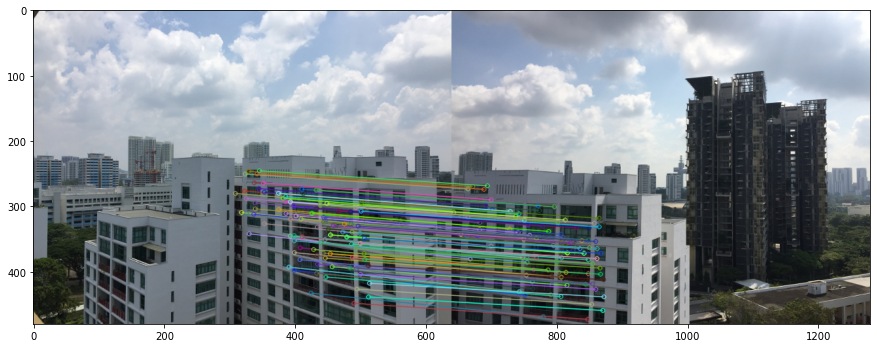

In [14]:
# method 1
# plot inliers matching line
match_bestres = cv2.drawMatches(img1, kp1, img2, kp2, match_best, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure( figsize=(15,15) )
plt.imshow(match_bestres)
plt.show()

In [15]:
# method 2 
# plot inliers matching line
in_images=np.hstack((im1,im2))
line_num = len(match_best)
x_com,y_com,_ = im1.shape

line_size = 1
thickness = 1 

for index in match_best:
    # random color
    bgr = np.random.randint(0, 255, 3, dtype=np.int32)

    ps = int(index.queryIdx)
    pe = int(index.trainIdx)

    cv2.line(in_images,[int(kp1[ps].pt[0]),int(kp1[ps].pt[1])],
             [int(kp2[pe].pt[0]+y_com),int(kp2[pe].pt[1])],(int(bgr[0]),int(bgr[1]),int(bgr[2])),thickness)

# show the image
cv2.imshow('Inliers Images',in_images)
cv2.waitKey(0)
cv2.destroyWindow('Inliers Images')
cv2.waitKey(1)

-1

### 3.Stitch the images together using the best homography matrix and show the result: 

In [16]:
# recalculate H matrix with all inliers

# change the inliers from tuple to list
N = len(match_best)
in1 = np.zeros([N,2])
in2 = np.zeros([N,2])

# Get the coordinate of keypoint
for i in range(N):
    for j in range(2):
        in1[i] = [kp1[match_best[i].queryIdx].pt[1],kp1[match_best[i].queryIdx].pt[0]]
        in2[i] = [kp2[match_best[i].trainIdx].pt[1],kp2[match_best[i].trainIdx].pt[0]]

# compare the Homography compute from the random points and the inliers
in_points = np.concatenate((in1,in2),axis = 0)
H_best = hmat(in_points)
print(H_best)
print(HH)

[[ 1.78132600e+00  4.96584314e-01 -1.85550742e+02]
 [-9.70850543e-02  2.15672791e+00 -6.36120828e+02]
 [-9.93279785e-05  1.74651746e-03  1.00000000e+00]]
[[ 2.12500515e+00 -1.07836467e-01 -6.23361524e+02]
 [ 4.92644080e-01  1.72512406e+00 -1.76022125e+02]
 [ 1.72699178e-03 -1.62619334e-04  1.00000000e+00]]


In [17]:
# transform h1 to h2
def get_size(h1,H):
    [row,col,c] = h1.shape
    
    # 4 cornor of the image h1
    lt = np.array([[0,0,1]])
    rt = np.array([[0,col,1]])
    lb = np.array([[row,0,1]])
    rb = np.array([[row,col,1]])
    
    # edge matrix
    edge = np.concatenate((lt,rt,lb,rb),axis = 0).T
    
    T_edge = np.dot(H,edge)
    # normalize
    T_edge = T_edge[0:2,:]/T_edge[2,:]
    T_edge = T_edge
    
    return np.max(T_edge[0,:]),np.min(T_edge[0,:]),np.max(T_edge[1,:]),np.min(T_edge[1,:])
    

In [18]:
# build a canvas
def get_canvas(im1,im2,Hi):
    # Hi is im2 to im1
    [row1,col1,c] = im1.shape
    [row2,col2,c] = im2.shape

    # get the edge
    [x_max,x_min,y_max,y_min] = get_size(im2,Hi)
    print([x_min,x_max,y_min,y_max])
    x_minus = int(np.min([0,x_min])-10)
    x_plus = int(np.max([0,x_max-row1])+10)
    y_minus = int(np.min([0,y_min])-10)
    y_plus = int(np.max([0,y_max-col1])+10)
    
    # x direction adding space
    add_x_minus = np.zeros([-x_minus,col1,c])
    add_x_plus = np.zeros([x_plus,col1,c])
    
    # y direction adding space
    add_y_minus = np.zeros([-x_minus+row1+x_plus,-y_minus,c])
    add_y_plus = np.zeros([-x_minus+row1+x_plus,y_plus,c])
    
    # concatenate the adding space with im1
    canvas = np.concatenate((add_x_minus,im1,add_x_plus),axis = 0)
    canvas = np.concatenate((add_y_minus,canvas,add_y_plus),axis = 1)
    
    return canvas.astype(int),[x_minus,y_minus]



[-236.12025003082772, 596.9843595666621, 295.92263200394143, 1247.5291832430132]
[-246, -10]


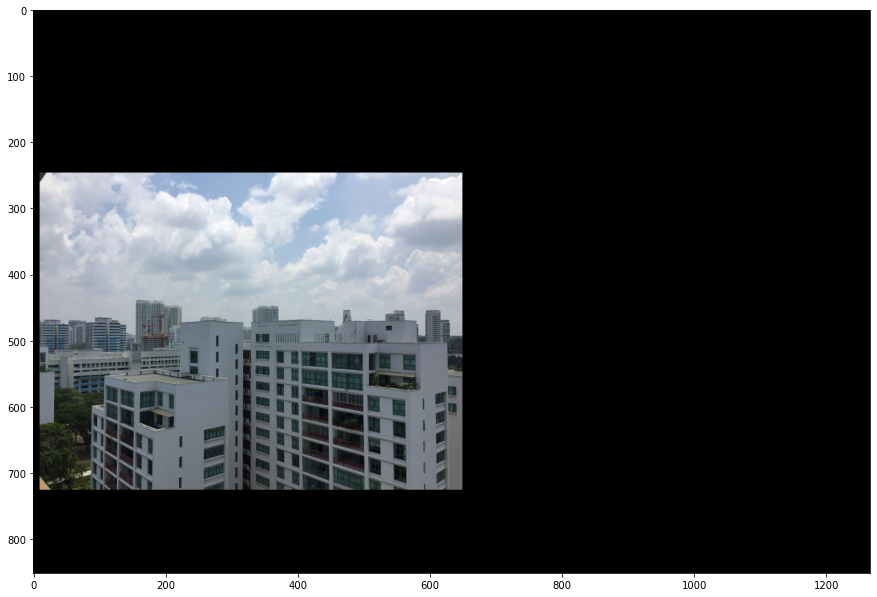

In [19]:
# im2 to im1
Hi = linalg.inv(H_best)

# get canvas and axis compensation
canvas,compensation = get_canvas(img1,img2,Hi)

# show the canvas
print(compensation)
plt.figure( figsize=(15,15) )
plt.imshow(canvas)

In [20]:
def trans2im1(canvas,im2,Hi,compensation):
    # the wight of the im1 when overlay
    w = 0.6
    
    # step of the transmitting 1/step
    step = 3
    [row,col,c] = im2.shape
    
    # draw im2 on the canvas
    for j in range(0,row*step):
        for k in range(0,col*step):
            # positon: points of im2 in im1 plane 
            p = np.array([[j/step,k/step,1]]).T
            Tp = np.dot(Hi,p)

            # normalize and move the image
            x2 = int(round(Tp[0,0]/Tp[2,0])-compensation[0])
            y2 = int(round(Tp[1,0]/Tp[2,0])-compensation[1])
            
            # position in im1
            x1 = int(j/step)
            y1 = int(k/step)

            if np.any(canvas[x2,y2] > 0):
                canvas[x2,y2] = w * canvas[x2,y2][:] + (1 - w) * im2[x1,y1][:]
            else:
                canvas[x2,y2] = im2[x1,y1][:]
    
    return canvas.astype(int)
    

In [21]:
# transfer im2 to im1 plane
Tim1 = trans2im1(canvas,img2,Hi,compensation)

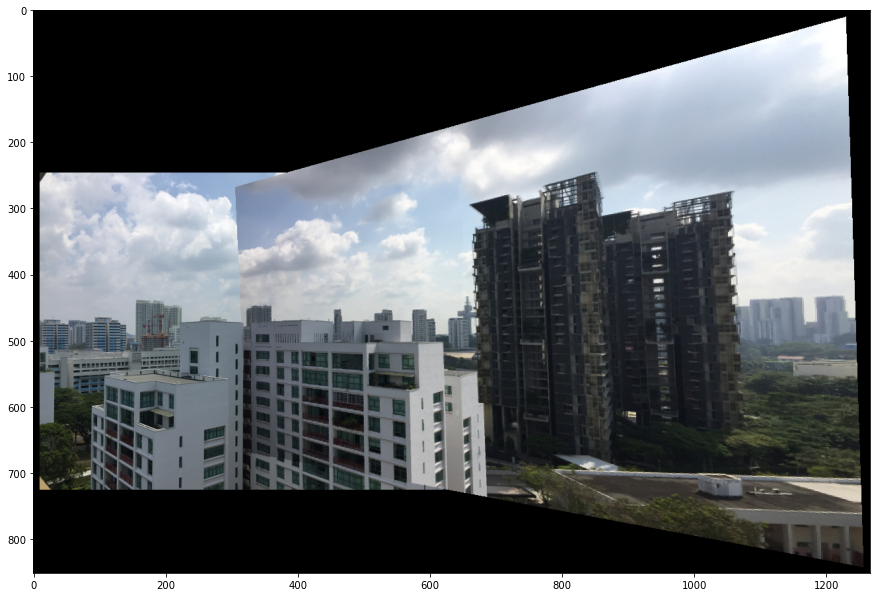

In [22]:
# show the sitching image
plt.figure( figsize=(15,15) )
plt.imshow(Tim1)